In [1]:
import gammapy 
print(f'loaded gammapy version: {gammapy.__version__} ' )
print(f'Supposed to be 1.0 (21-12-2022)' )
print(gammapy)

loaded gammapy version: 1.1.dev320+g92a6eb9f4 
Supposed to be 1.0 (21-12-2022)
<module 'gammapy' from '/home/hpc/caph/mppi045h/gammapy/gammapy/__init__.py'>


$\mathcal{L} = \exp(-\lambda) \frac{1}{n!} \lambda ^n$ \
for easier minimalisation: \
$-2 \log (\mathcal{L})= - 2 n \log (\lambda) + 2 \lambda $

In [2]:
#get_ipython().system('jupyter nbconvert --to script 1-Nui_Par_Fitting.ipynb')
import pyximport

pyximport.install()
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import gammapy

# from gammapy.datasets import MapDataset
from gammapy.maps import Map
from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit,  Parameters, Covariance , Parameter
from gammapy.datasets import MapDataset ,Datasets#, MapDatasetNuisance
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    create_crab_spectral_model,
    SkyModel,
    PointSpatialModel,
    ShellSpatialModel,
    GeneralizedGaussianSpatialModel,
    TemplateSpatialModel,
    LogParabolaSpectralModel,
    GaussianSpatialModel,
    DiskSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
    PowerLawNuisanceSpectralModel,
    PowerLawNormNuisanceSpectralModel
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys

from Dataset_Creation import sys_dataset


## Read dataset

spatial binsize =  [0.08] deg
MapDataset
----------

  Name                            : 85D72qt1 

  Total counts                    : 388209 
  Total background counts         : 360331.31
  Total excess counts             : 27877.69

  Predicted counts                : 361333.07
  Predicted background counts     : 360331.34
  Predicted excess counts         : 1001.73

  Exposure min                    : 2.07e-01 m2 s
  Exposure max                    : 2.41e+11 m2 s

  Number of total bins            : 540000 
  Number of fit bins              : 180191 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : -924522.99

  Number of models                : 2 
  Number of parameters            : 11
  Number of free parameters       : 7

  Component 0: SkyModel
  
    Name                      : Source
    Datasets names            : None
    Spectral model type       : PowerLawSpectralModel
    Spatial  model type       : GaussianSpatialModel
    Temporal model ty

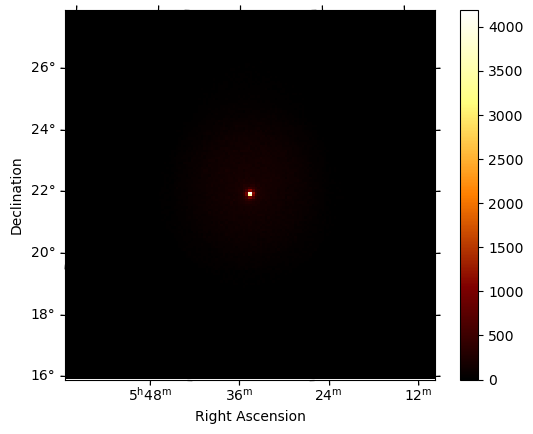

In [3]:
source = 'Crab'
path = '/home/vault/caph/mppi062h/repositories/HESS_3Dbkg_syserror/2-error_in_dataset'
path_crab = '/home/hpc/caph/mppi045h/3D_analysis/N_parameters_in_L/nuisance_summary/Crab'


dataset_load = MapDataset.read(f'{path}/{source}/stacked.fits')
dataset_load = dataset_load.downsample(4)
models = Models.read(f"{path_crab}/standard_model.yml")
model_spectrum  = PowerLawSpectralModel(
    index=2.3,
    amplitude="1e-12 TeV-1 cm-2 s-1",    )
source_model = SkyModel(spatial_model = models['main source'].spatial_model ,
                       spectral_model = model_spectrum,
                       name = "Source")    
models = Models([source_model])

bkg_model = FoVBackgroundModel(dataset_name=dataset_load.name)
bkg_model.parameters['tilt'].frozen  = False
models.append(bkg_model)
dataset_load.models = models

dataset_asimov = dataset_load.copy()
dataset_asimov.counts = dataset_load.npred()
models = Models(source_model.copy(name="Source"))
bkg_model = FoVBackgroundModel(dataset_name=dataset_asimov.name)
bkg_model.parameters['tilt'].frozen  = False
models.append(bkg_model)
dataset_asimov.models = models

    
dataset_load.counts.sum_over_axes().plot(add_cbar=1)
binsize = dataset_load.geoms["geom"].width[1] / dataset_load.geoms["geom"].data_shape[1]
print(
    "spatial binsize = ",
    binsize
)

print(dataset_load)

## Asimov Cases

In [4]:
factor_neg = -0.1
factor_pos = +0.1

sigma = 0.1

In [26]:
sys_d_cor = sys_dataset(dataset_asimov, 0, False)
dataset_cor_N = sys_d_cor.create_dataset_N(sigma)

sys_d_neg = sys_dataset(dataset_asimov, factor_neg, False)
dataset_neg_N = sys_d_neg.create_dataset_N(sigma)

sys_d_pos = sys_dataset(dataset_asimov, factor_pos, False)
dataset_pos_N = sys_d_pos.create_dataset_N(sigma)

sigma_a = 0.1
sigma_n = 0.1
#sigma_na = 0.9
sigma_na = 0.01

#penalising_covmatrix = [[1/sigma_a**2 + 1/sigma_na ** 2,  - 1/sigma_na**2],
#                        [  - 1/sigma_na**2             ,    1/sigma_n**2 + 1/sigma_na ** 2]]


penalising_covmatrix = [[1/sigma_a**2]]

penalising_invcovmatrix =  penalising_covmatrix

dataset_pos_N.penalising_invcovmatrix = penalising_invcovmatrix
dataset_cor_N.penalising_invcovmatrix = penalising_invcovmatrix
dataset_neg_N.penalising_invcovmatrix = penalising_invcovmatrix

datasets  = [dataset_pos_N, dataset_cor_N, dataset_neg_N]

#for d in datasets:
#    for par in ['norm_nuisance', 'amplitude_nuisance']:
#        d.models.parameters[par].max = 0.2
#        d.models.parameters[par].min = -0.2
    #d.models.parameters['norm_nuisance'].frozen = True




4
4
4
4
4
4
MapDataset
----------

  Name                            : dataset N 

  Total counts                    : 361333 
  Total background counts         : 360331.31
  Total excess counts             : 1001.76

  Predicted counts                : 361333.07
  Predicted background counts     : 360331.34
  Predicted excess counts         : 1001.73

  Exposure min                    : 2.07e-01 m2 s
  Exposure max                    : 2.41e+11 m2 s

  Number of total bins            : 540000 
  Number of fit bins              : 180191 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : -753580.09

  Number of models                : 2 
  Number of parameters            : 12
  Number of free parameters       : 6

  Component 0: SkyModel
  
    Name                      : SourceN
    Datasets names            : None
    Spectral model type       : PowerLawNuisanceSpectralModel
    Spatial  model type       : GaussianSpatialModel
    Temporal model type       

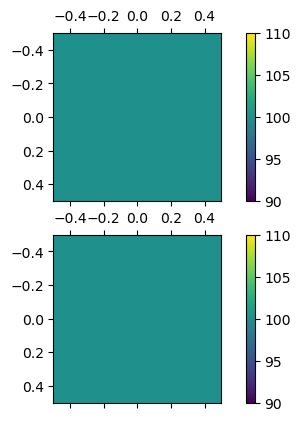

In [6]:
fig, ax = plt.subplots(2,1)
#ax = fig.add_subplot(111)
cax = ax[0].matshow(penalising_covmatrix)  # interpolation='nearest')
fig.colorbar(cax);
cax = ax[1].matshow(penalising_invcovmatrix)  # interpolation='nearest')
fig.colorbar(cax);

corr
neg
pos
CPU times: user 8.94 s, sys: 195 ms, total: 9.14 s
Wall time: 10.2 s


<AxesSubplot: >

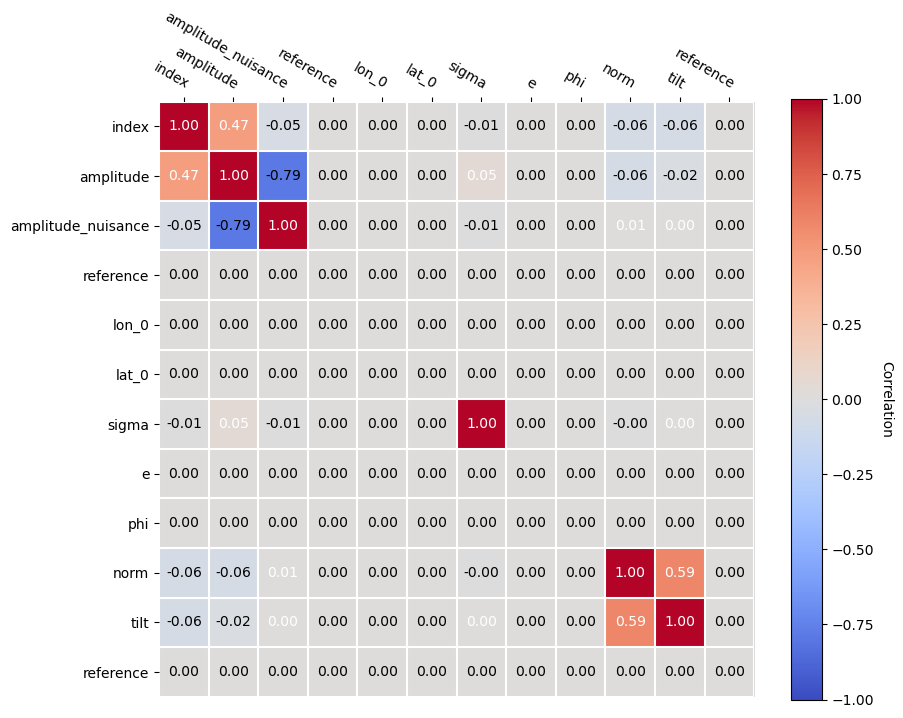

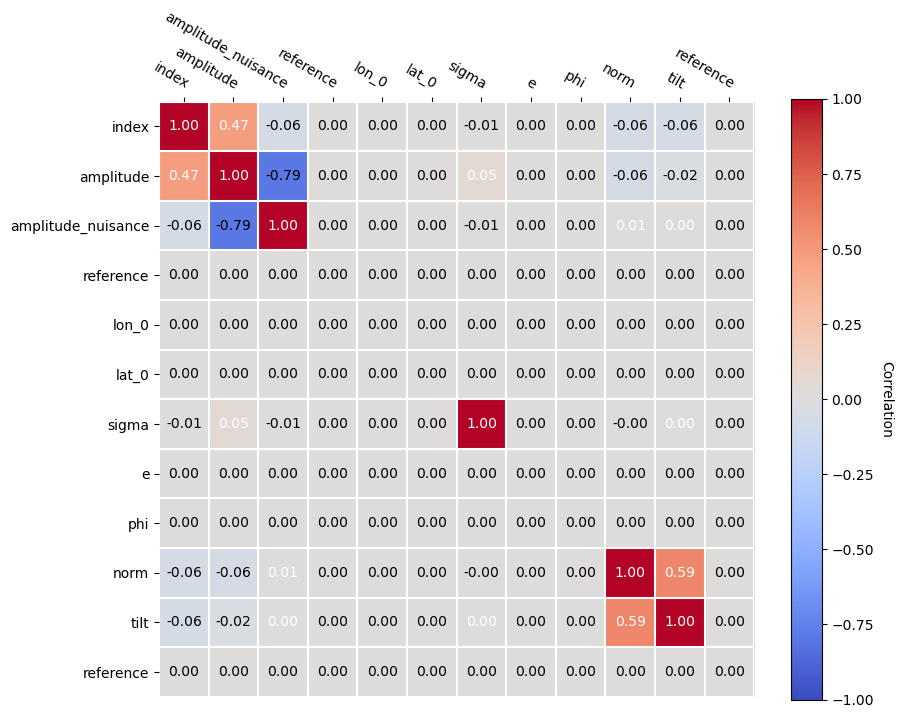

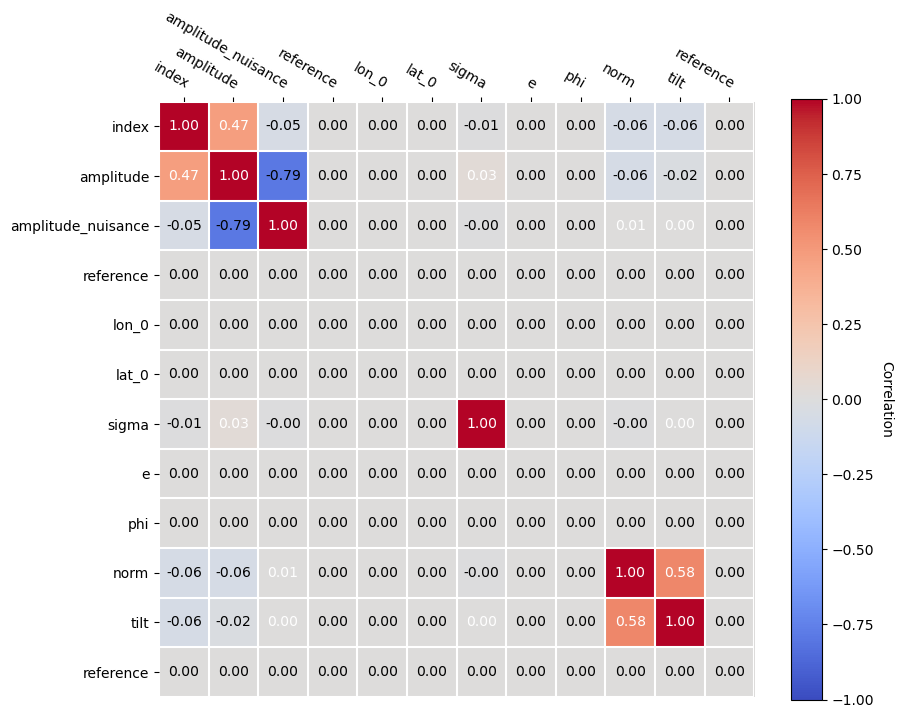

In [7]:
%%time
print("corr")
fit_cor = Fit(store_trace=False)
result_cor = fit_cor.run(dataset_cor_N)
        
print("neg")
fit_neg = Fit(store_trace=False)
result_neg = fit_neg.run(dataset_neg_N)

print("pos")
fit_pos = Fit(store_trace=False)
result_pos = fit_pos.run(dataset_pos_N)


dataset_pos_N.models.covariance = fit_pos.covariance(dataset_pos_N).matrix
dataset_pos_N.models.covariance.plot_correlation()

dataset_neg_N.models.covariance = fit_neg.covariance(dataset_neg_N).matrix
dataset_neg_N.models.covariance.plot_correlation()

dataset_cor_N.models.covariance = fit_cor.covariance(dataset_cor_N).matrix
dataset_cor_N.models.covariance.plot_correlation()

In [8]:
datasets_short = [dataset_neg_N, dataset_cor_N, dataset_pos_N]
print("best fit amplitude")
amplitudes_N = []
m = dataset_asimov.models[0]
value = m.parameters['amplitude'].value 
error = m.parameters['amplitude'].error
amplitudes_N.append((value, error))
print('====')
print('Input')
print(f'{value} pm {error}')
print('====')
for d in datasets_short:
    m = d.models[0]
    value = m.parameters['amplitude'].value 
    error = m.parameters['amplitude'].error
    amplitudes_N.append((value, error))
    print(f'{value} pm {error}')
print()
print("best fit Index")
indices_N = []
m = dataset_asimov.models[0]
value = m.parameters['index'].value 
error = m.parameters['index'].error
indices_N.append((value, error))
print('====')
print('Input')
print(f'{value} pm {error}')
print('====')
for d in datasets_short:
    m = d.models[0]
    value = m.parameters['index'].value 
    error = m.parameters['index'].error
    indices_N.append((value, error))
    print(f'{value} pm {error}')
print()

print("Best Fit bkg Norm")
norms_N = []
value = dataset_asimov.background_model.parameters['norm'].value 
error = dataset_asimov.background_model.parameters['norm'].error
norms_N.append((value, error))
print('====')
print('Input')
print(f'{value} pm {error}')
print('====')
for d in datasets_short:
    value = d.background_model.parameters['norm'].value 
    error = d.background_model.parameters['norm'].error
    print(f'{value} pm {error}')
    norms_N.append((value, error))
    

best fit amplitude
====
Input
1e-12 pm 0.0
====
9.11397481232464e-13 pm 1.336641220053057e-13
1e-12 pm 1.4623763834790134e-13
1.1106040249699584e-12 pm 1.6207083590048613e-13

best fit Index
====
Input
2.3 pm 0.0
====
2.300406605605556 pm 0.06179833491553363
2.3 pm 0.06180678084529032
2.301309204508598 pm 0.06185289501883676

Best Fit bkg Norm
====
Input
1.0 pm 0
====
1.0000089240797507 pm 0.0020659863087889503
1.0 pm 0.002062427628225152
0.9999931535648549 pm 0.0020659465553467104


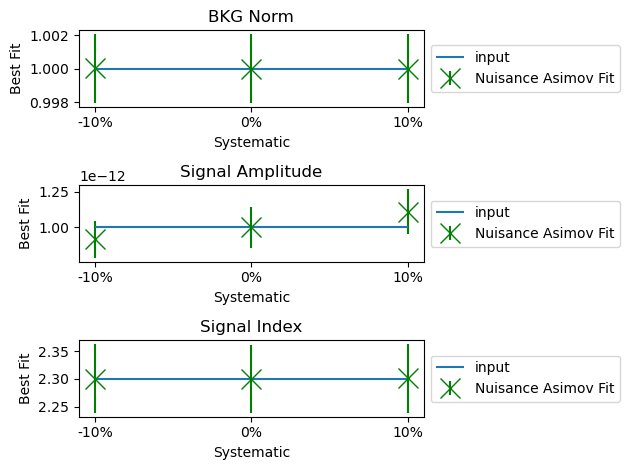

In [9]:
fig, axs = plt.subplots(3,1)

axs[0].set_title("BKG Norm")
axs[1].set_title("Signal Amplitude")
axs[2].set_title("Signal Index")


labels_sys = [ '-10%', '0%', '10%']
label = "Nuisance Asimov Fit"

for i, a in enumerate(norms_N[1:]):
    axs[0].errorbar(x= i+1, y = a[0], yerr = a[1], fmt= 'x', color =  'green',markersize=14,
                   label = label)
axs[0].hlines( norms_N[0][0], 1, 3, label = "input")

for i, a in enumerate(amplitudes_N[1:]):
    axs[1].errorbar(x= i+1, y = a[0], yerr = a[1], fmt= 'x', color =  'green',markersize=14,
                   label = label)
axs[1].hlines( amplitudes_N[0][0], 1, 3, label = "input")

for i, a in enumerate(indices_N[1:]):
    axs[2].errorbar(x= i+1, y = a[0], yerr = a[1], fmt= 'x', color =  'green',markersize=14,
                   label = label)
axs[2].hlines( indices_N[0][0], 1, 3, label = "input")

plt.tight_layout()
for a in axs:
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    a.legend(by_label.values(), by_label.keys(),
            loc='center left', bbox_to_anchor=(1, 0.5))
    a.set_ylabel('Best Fit'); 
    a.set_xlabel('Systematic'); 
    a.set_xticks(np.arange(3)+1,labels_sys)

plt.tight_layout()    
fig.savefig("best_fit_parameters_corr.pdf")   


index
amplitude
amplitude_nuisance
index
amplitude
amplitude_nuisance
index
amplitude
amplitude_nuisance
index
amplitude
amplitude_nuisance
index
amplitude
amplitude_nuisance


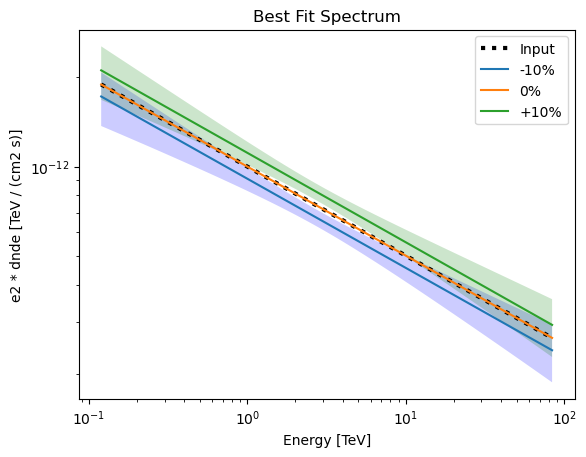

In [10]:
true_energy = dataset_cor_N.exposure.geom.axes[0].center.value


fig,ax = plt.subplots()
energy_bounds = energy_bounds =(true_energy[0], true_energy[-1] ) * u.TeV
dataset_asimov.models[0].spectral_model.plot(energy_bounds, energy_power = 2, ax =ax, 
                                label = "Input", color = 'black', linewidth = 3, linestyle ='dotted')

dataset_neg_N.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = ax,
                                label = "-10%")
dataset_neg_N.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = ax,
                                                       facecolor='blue')

dataset_cor_N.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = ax,
                                label = "0%")
                                   
#dataset_cor_N.models['Source'].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = ax,
#                                                       facecolor='orange')


                               
dataset_pos_N.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = ax,
                                label = "+10%")
dataset_pos_N.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = ax,
                                                        facecolor = 'green')


plt.legend()

plt.title("Best Fit Spectrum")
fig = plt.gcf()
#fig.savefig("plots/2_spectrum.pdf")

-0.0013147644138852346 0.10887168522941025
0.0 0.10867100436889218
0.0018657511214966794 0.10855619240250512


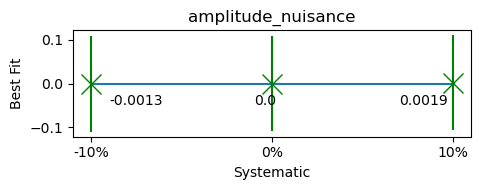

In [11]:
n_nui = len(dataset_neg_N.models.parameters.penalised_parameters)
fig, a  = plt.subplots(n_nui, 1, figsize = (5,2* n_nui))
if n_nui ==1:
    a = [a]
label = 'Nuisance Fit'
iss = [1.1, 1.9, 2.7]
for j, par_name in enumerate(dataset_neg_N.models.parameters.penalised_parameters.names):
    for i, d in enumerate([dataset_neg_N, dataset_cor_N, dataset_pos_N]):
        value = d.models.parameters[par_name].value
        error = d.models.parameters[par_name].error
        print(value, error)

        a[j].errorbar(x= i+1, y = value, yerr = error, fmt= 'x', color =  'green',markersize=14,
                       label = label)
        a[j].text(iss[i],-0.05, f'{value:.2}', )
    a[j].hlines( 0., 1, 3, label = "input")

    a[j].set_ylabel('Best Fit' ); 
    a[j].set_title(par_name)
    a[j].set_xlabel('Systematic'); 
    a[j].set_xticks(np.arange(3)+1,labels_sys);

plt.tight_layout()
#fig.savefig("plots/2_best_fit_nui.pdf")

## Comparison

In [12]:

with open('data/norms.yaml') as file:
    norms = yaml.load( file, Loader=yaml.FullLoader)
with open('data/amplitudes.yaml') as file:
    amplitudes = yaml.load( file, Loader=yaml.FullLoader)
with open('data/indices.yaml') as file:
    indices = yaml.load( file, Loader=yaml.FullLoader)
    


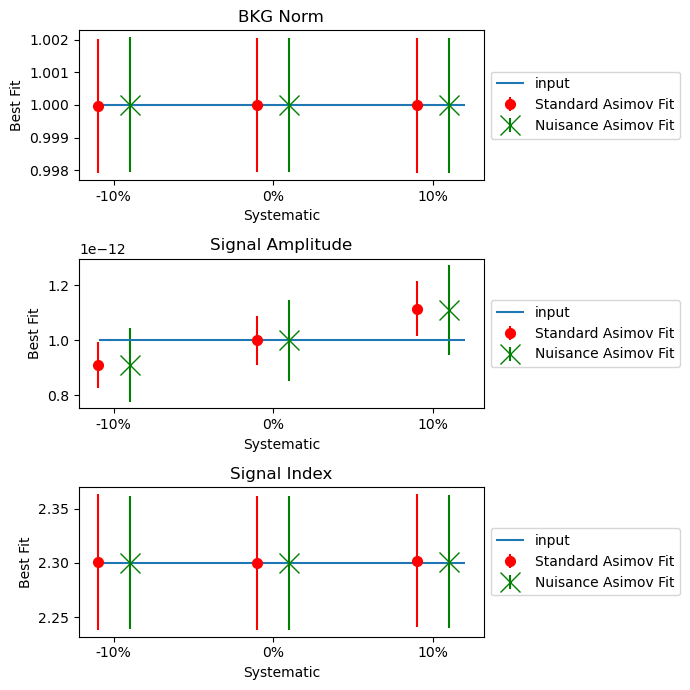

In [13]:
fig, axs = plt.subplots(3,1, figsize= (7, 7))

axs[0].set_title("BKG Norm")
axs[1].set_title("Signal Amplitude")
axs[2].set_title("Signal Index")


labels_sys = [ '-10%', '0%', '10%']

for i, a in enumerate(norms[1:]):
    label = "Standard Asimov Fit"
    axs[0].errorbar(x= i+0.9, y = a[0], yerr = a[1], fmt= 'o', color =  'red',markersize = 7,
                   label = label)
for i, a in enumerate(amplitudes[1:]):
    axs[1].errorbar(x= i+0.9, y = a[0], yerr = a[1], fmt= 'o', color =  'red',markersize = 7,
                   label = label)
for i, a in enumerate(indices[1:]):
    axs[2].errorbar(x= i+0.9, y = a[0], yerr = a[1], fmt= 'o', color =  'red',markersize = 7,
                   label = label)
    
for i, a in enumerate(norms_N[1:]):
    label = "Nuisance Asimov Fit"
    axs[0].errorbar(x= i+1.1, y = a[0], yerr = a[1], fmt= 'x', color =  'green',markersize=14,
                   label = label)
for i, a in enumerate(amplitudes_N[1:]):
    axs[1].errorbar(x= i+1.1, y = a[0], yerr = a[1], fmt= 'x', color =  'green',markersize=14,
                   label = label)
for i, a in enumerate(indices_N[1:]):
    axs[2].errorbar(x= i+1.1, y = a[0], yerr = a[1], fmt= 'x', color =  'green',markersize=14,
                   label = label)
axs[2].hlines( indices[0][0], 0.91, 3.2, label = "input")
axs[0].hlines( norms[0][0], 0.91, 3.2, label = "input")
axs[1].hlines( amplitudes[0][0], 0.91, 3.2, label = "input")

plt.tight_layout()
for ax in axs:
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), ncol = 1, 
            loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_ylabel('Best Fit'); 
    ax.set_xlabel('Systematic'); 
    ax.set_xticks(np.arange(3)+1,labels_sys)

    
#axs[0].set_ylim(0.85, 1.15)
plt.tight_layout()    
fig.savefig("plots/2_best_fit_parameters_comparison.pdf")   


In [25]:
amplitudes_N

[(1e-12, 0.0),
 (9.11397481232464e-13, 1.336641220053057e-13),
 (1e-12, 1.4623763834790134e-13),
 (1.1106040249699584e-12, 1.6207083590048613e-13)]

In [24]:
amplitudes

[(1e-12, 0),
 (9.101945407831386e-13, 8.359415343349378e-14),
 (1e-12, 8.982377778353663e-14),
 (1.1150443699368725e-12, 9.998509805855401e-14)]

### Spectrum

In [14]:
dataset_st_neg = dataset_neg_N.copy()
dataset_st_neg.models = Models.read("data/1_model_neg.yml")

dataset_st_pos = dataset_pos_N.copy()
dataset_st_pos.models = Models.read("data/1_model_pos.yml")

dataset_st_cor = dataset_cor_N.copy()
dataset_st_cor.models = Models.read("data/1_model_cor.yml")

In [15]:
dataset_neg_N.models[0].spectral_model.parameters['amplitude_nuisance'].frozen = True
dataset_pos_N.models[0].spectral_model.parameters['amplitude_nuisance'].frozen = True
dataset_cor_N.models[0].spectral_model.parameters['amplitude_nuisance'].frozen = True

index
amplitude
index
amplitude
index
amplitude
index
amplitude
index
amplitude
index
amplitude
index
amplitude
index
amplitude
index
amplitude
index
amplitude
index
amplitude
index
amplitude


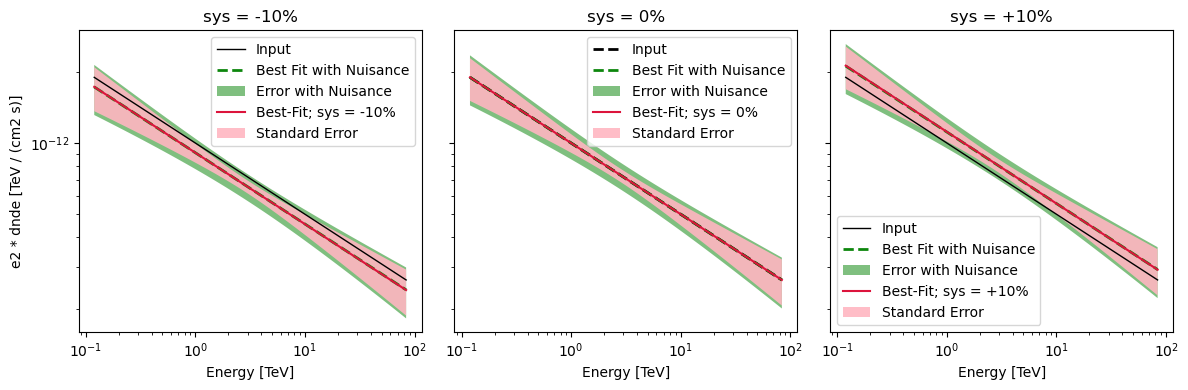

In [16]:
true_energy = dataset_cor_N.exposure.geom.axes[0].center.value
energy_bounds = (true_energy[0], true_energy[-1] ) * u.TeV
fig,axs = plt.subplots(1,3, sharey=True,figsize = (12,4))

for i,ax in enumerate(axs):
    if i ==1:
         dataset_asimov.models[0].spectral_model.plot(energy_bounds, energy_power = 2, ax =ax, 
                                label = "Input", color = 'black', linewidth = 2, linestyle="dashed")
    else:
        dataset_asimov.models[0].spectral_model.plot(energy_bounds, energy_power = 2, ax =ax, 
                                label = "Input", color = 'black', linewidth = 1, )


dataset_neg_N.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs[0],
                                                       color='green',
                                                         label="Best Fit with Nuisance",
                                                        alpha = 0.95,
                                                       linestyle='dashed', linewidth= 2)        
dataset_neg_N.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs[0],
                                                       facecolor='green',
                                                         label="Error with Nuisance",
                                                        alpha = 0.5)
dataset_st_neg.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs[0],
                                label = "Best-Fit; sys = -10%", color = "crimson")
dataset_st_neg.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs[0],
                                                       facecolor='lightpink',
                                                          alpha = 0.9,
                                                          label= "Standard Error"
                                                         )
### cor 
dataset_cor_N.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs[1],color = 'green',
                                                         label="Best Fit with Nuisance",
                                                        alpha = 0.95,
                                                       linestyle='dashed', linewidth= 2)
dataset_cor_N.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs[1],
                                                       facecolor='green',
                                                         label="Error with Nuisance",
                                                        alpha = 0.5)
dataset_st_cor.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs[1],
                                label = "Best-Fit; sys = 0%", color = "crimson")
dataset_st_cor.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs[1],
                                                       facecolor='lightpink',
                                                          alpha = 0.9,
                                                          label= "Standard Error"
                                                         )
### pos 
dataset_pos_N.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs[2],color = 'green',
                                                               label="Best Fit with Nuisance",
                                                        alpha = 0.95,
                                                       linestyle='dashed', linewidth= 2)                                              

dataset_pos_N.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs[2],
                                                       facecolor='green',
                                                         label="Error with Nuisance",
                                                        alpha = 0.5)
dataset_st_pos.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs[2],
                                label = "Best-Fit; sys = +10%", color = "crimson")
dataset_st_pos.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs[2],
                                                       facecolor='lightpink',
                                                          alpha = 0.9,
                                                          label= "Standard Error"
                                                         )
[a.legend() for a in axs]
axs[0].set_title("sys = -10%"); axs[1].set_title("sys = 0%"); axs[2].set_title("sys = +10%"); 

axs[1].set_ylabel('')
axs[2].set_ylabel('')

plt.tight_layout()
fig = plt.gcf()
fig.savefig("plots/2_spectrum.pdf")

<AxesSubplot: >

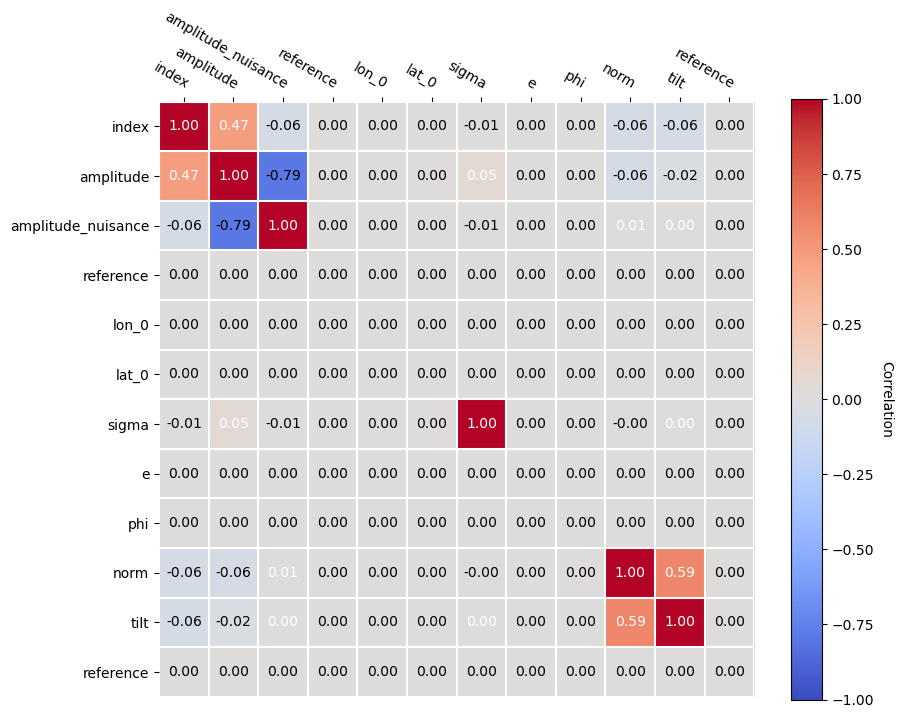

In [17]:
dataset_neg_N.models.covariance.plot_correlation()

In [18]:
from gammapy.stats import  gaussian_penality
values = np.linspace(-0.1, 0.1, 10)
pen = []
stat = []
for v in values:
    #dataset_pos_N.models.parameters['norm_nuisance'].value = v
    dataset_pos_N.models.parameters['amplitude_nuisance'].value = v
    
    penalty = gaussian_penality(dataset_pos_N.models.parameters.penalised_parameters,
                                     dataset_pos_N._penalising_invcovmatrix)
    stat_sum = dataset_pos_N.stat_sum()  - penalty
    
    pen.append(penalty)
    stat.append(stat_sum)
pen = np.array(pen)
stat = np.array(stat)  



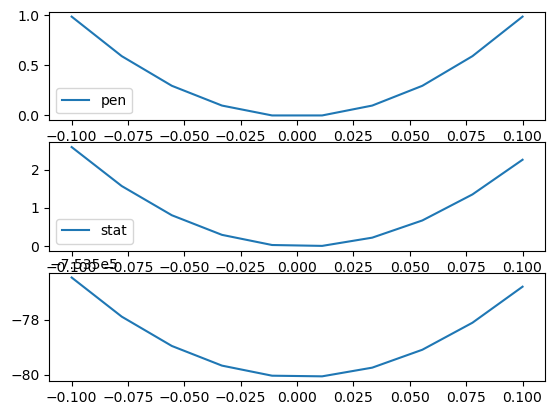

In [19]:
fig, ax = plt.subplots(3,1)
ax[0].plot(values, pen - np.min(pen), label= 'pen')
ax[1].plot(values, stat - np.min(stat), label= 'stat')
ax[2].plot(values, stat +pen , label= 'stat +pen')

ax[1].legend()
ax[0].legend()

In [20]:
dataset_pos_N.models[0].spectral_model.parameters.to_table()

type,name,value,unit,error,min,max,frozen,is_norm,is_penalised,link
str8,str18,float64,str14,float64,float64,float64,bool,bool,bool,str1
spectral,index,2.3013e+00,,6.185e-02,nan,nan,False,False,False,
spectral,amplitude,1.1106e-12,cm-2 s-1 TeV-1,1.621e-13,nan,nan,False,True,False,
spectral,amplitude_nuisance,1.0000e-01,,1.086e-01,nan,nan,True,False,True,
spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,False,False,


<AxesSubplot: >

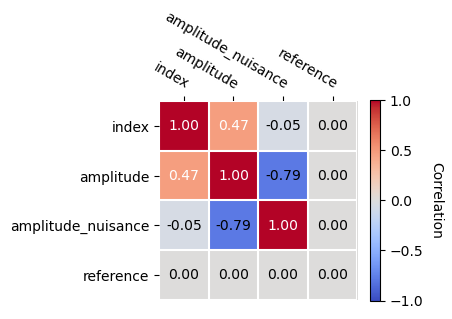

In [21]:
dataset_pos_N.models[0].spectral_model.covariance.plot_correlation()

In [22]:
cov =dataset_pos_N.models[0].spectral_model.covariance
print(cov)

[[ 3.82578062e-03  4.71585956e-15 -3.58577070e-04  0.00000000e+00]
 [ 4.71585956e-15  2.62669558e-26 -1.38663491e-14  0.00000000e+00]
 [-3.58577070e-04 -1.38663491e-14  1.17844469e-02  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]


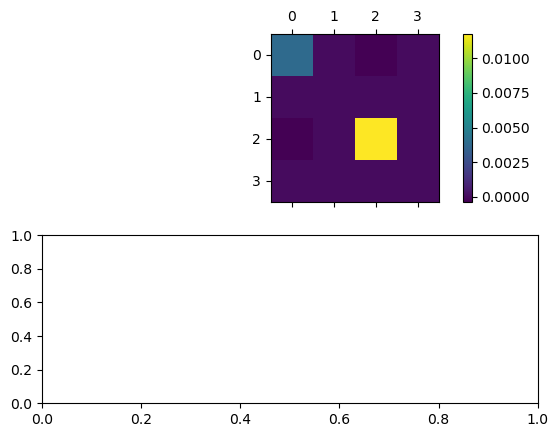

In [23]:
fig, ax = plt.subplots(2,1)
#ax = fig.add_subplot(111)
cax = ax[0].matshow(cov)  # interpolation='nearest')
fig.colorbar(cax);